# Linear Regression 기반의 검색 빈도수를 이용한 주가예측

# 0. Install packages

In [ ]:
!pip install finance-datareader
!pip install -U finance-datareader # 업데이트

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import json
import re

# 1. Prepare datasests

## 1-1. 주가 데이터 불러오기

In [ ]:
# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

# 한국거래소에 상장된 모든 종목 리스트 가져오기
import FinanceDataReader as fdr
df_krx = fdr.StockListing('KRX')
df_krx.head()

,Symbol,Market,Name,Sector,Industry,ListingDate,SettleMonth,Representative,HomePage,Region
0,060310,KOSDAQ,3S,전자부품 제조업,반도체 웨이퍼 캐리어,2002-04-23,03월,김세완,http://www.3sref.com,서울특별시
1,095570,KOSPI,AJ네트웍스,산업용 기계 및 장비 임대업,"렌탈(파렛트, OA장비, 건설장비)",2015-08-21,12월,"박대현, 손삼달",http://www.ajnet.co.kr,서울특별시
2,006840,KOSPI,AK홀딩스,기타 금융업,지주사업,1999-08-11,12월,"채형석, 이석주(각자 대표이사)",http://www.aekyunggroup.co.kr,서울특별시
3,054620,KOSDAQ,APS홀딩스,기타 금융업,인터넷 트래픽 솔루션,2001-12-04,12월,정기로,http://www.apsholdings.co.kr,경기도
4,265520,KOSDAQ,AP시스템,특수 목적용 기계 제조업,디스플레이 제조 장비,2017-04-07,12월,김영주,http://www.apsystems.co.kr,경기도


In [ ]:
df = fdr.DataReader('036570','2020-01-01', '2022-04-12') # NCsoft 주가를 2020년부터 현시점까지 가져온다

In [ ]:
df

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,542000,545000,539000,541000,40246,0.000000
2020-01-03,547000,568000,542000,565000,112404,0.044362
2020-01-06,562000,587000,562000,579000,107006,0.024779
2020-01-07,583000,596000,574000,594000,84378,0.025907
2020-01-08,587000,604000,584000,604000,109267,0.016835
...,...,...,...,...,...,...
2022-04-06,475000,483500,469000,474000,96750,-0.012500
2022-04-07,469000,471500,462000,462000,103079,-0.025316
2022-04-08,462500,466500,453500,458000,87055,-0.008658


In [ ]:
df = df.fillna(0)

(array([737425., 737516., 737607., 737699., 737791., 737881., 737972.,
        738064., 738156., 738246.]),
 <a list of 10 Text major ticklabel objects>)

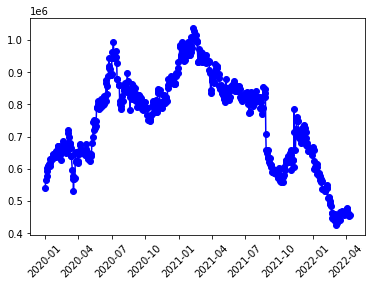

In [ ]:
plt.plot(df['Close'], 'bo-')
plt.xticks(rotation=45)

## 1-2. Naver API 키워드 검색 데이터 불러오기

In [ ]:
import os
import sys
import urllib.request
client_id = "8sAydq_QSOxKcICuD2Og"
client_secret = "OruQjbmaXF"
url = "https://openapi.naver.com/v1/datalab/search";
body = "{\"startDate\":\"2020-01-01\",\"endDate\":\"2022-04-12\",\"timeUnit\":\"date\",\"keywordGroups\":[{\"groupName\":\"NCSoft_N\",\"keywords\":[\"NCSoft\",\"환불\",\"사건\"]}]}";

request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    #print(response_body.decode('utf-8'))
    search_count = response_body.decode('utf-8')
else:
    print("Error Code:" + rescode)

In [ ]:
search_count_json = json.loads(search_count)

In [ ]:
#search_count_json

## 1-3. 데이터 전처리 및 Merge하기

In [ ]:
for idx in range(len(search_count_json["results"])):
  
  df_json = pd.DataFrame(search_count_json["results"][idx]["data"])
  column_name = 'Key_Count'+str(idx)
  df_json.columns = ['Date', column_name]
  df_json['Date'] = pd.to_datetime(df_json['Date'])
  df_json.reset_index(drop=True)
  df_json.set_index("Date")
  #Please refer to the section of "Merging asof" in https://pandas.pydata.org/docs/user_guide/merging.html
  df = pd.merge_asof(df, df_json, on="Date", by="Date")

In [ ]:
df_all = df

In [ ]:
df_all

,Date,Open,High,Low,Close,Volume,Change,Key_Count0
0,2020-01-02,542000,545000,539000,541000,40246,0.000000,21.50878
1,2020-01-03,547000,568000,542000,565000,112404,0.044362,21.59516
2,2020-01-06,562000,587000,562000,579000,107006,0.024779,24.24416
3,2020-01-07,583000,596000,574000,594000,84378,0.025907,23.98502
4,2020-01-08,587000,604000,584000,604000,109267,0.016835,26.34609
...,...,...,...,...,...,...,...,...
558,2022-04-06,475000,483500,469000,474000,96750,-0.012500,23.40915
559,2022-04-07,469000,471500,462000,462000,103079,-0.025316,24.93521
560,2022-04-08,462500,466500,453500,458000,87055,-0.008658,22.91966
561,2022-04-11,450500,459000,449000,453500,59322,-0.009825,24.12899


In [ ]:
df_all["Change"].sum() # 전체 주가의 변동폭은 2020년부터 현재까지 증가일까 감소일까? 최종 주가는 빠졌는데 놀랍게도 증가함.. 이는 복리의 함정

0.07053067344563524

In [ ]:
df_all[df_all["Date"] > '2022-01-01']["Change"].sum() #조금 더 범위를 좁혀 그러면 2022년 전체 주가 변동폭만 검색해보자, 역시 폭락중 불쌍한 임교수

-0.3216858919029978

In [ ]:
df_all[df_all["Key_Count0"].notnull()]["Change"].sum() # 그렇다면 해당 키워드가 검색된 날만 뽑아 주가가 상승했는지 하락인지 살펴보자.

0.07053067344563524

In [ ]:
# Fill nan as 0
df_all = df_all.fillna(0)
df_all.any().isnull()

Date          False
Open          False
High          False
Low           False
Close         False
Volume        False
Change        False
Key_Count0    False
dtype: bool

In [ ]:
df_all

,Date,Open,High,Low,Close,Volume,Change,Key_Count0
0,2020-01-02,542000,545000,539000,541000,40246,0.000000,21.50878
1,2020-01-03,547000,568000,542000,565000,112404,0.044362,21.59516
2,2020-01-06,562000,587000,562000,579000,107006,0.024779,24.24416
3,2020-01-07,583000,596000,574000,594000,84378,0.025907,23.98502
4,2020-01-08,587000,604000,584000,604000,109267,0.016835,26.34609
...,...,...,...,...,...,...,...,...
558,2022-04-06,475000,483500,469000,474000,96750,-0.012500,23.40915
559,2022-04-07,469000,471500,462000,462000,103079,-0.025316,24.93521
560,2022-04-08,462500,466500,453500,458000,87055,-0.008658,22.91966
561,2022-04-11,450500,459000,449000,453500,59322,-0.009825,24.12899


## 1-4. Feature Selection

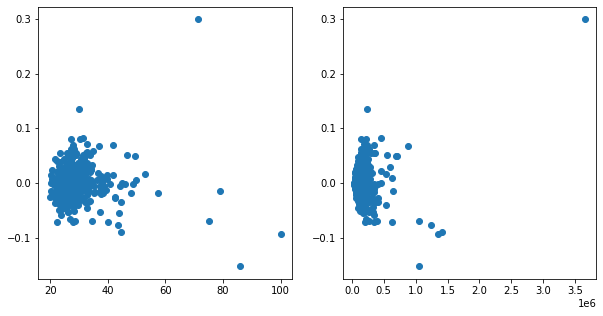

In [ ]:
## You need to visualized a relational graph
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(df_all["Key_Count0"], df_all["Change"])
ax2.scatter(df_all["Volume"], df_all["Change"])


# 2. Define Model

In [ ]:
class LinearModel(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearModel, self).__init__()
        self.linear_classifier = torch.nn.Linear(input_dim, output_dim, bias=True)

    def forward(self, x):
        x = self.linear_classifier(x.unsqueeze(0))
        return x

# 3. Define the loss function and the optimizer

In [ ]:
input_dim = 1
output_dim = 1
learning_rate = 0.001
model = LinearModel(input_dim, output_dim)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
loss_function = torch.nn.MSELoss()

# 4. Define train function

In [ ]:
def train(train_x, train_y, loss_function, optimizer, model):
  total_loss = []

  for idx in range(len(train_x)):
    model.train()
    optimizer.zero_grad()
    train_x_tensor = torch.tensor(train_x[idx]).float() #convert numpy to torch tensor
    train_y_tensor = torch.tensor(train_y[idx]).float()
    logit = model(train_x_tensor)
    loss = loss_function(logit, train_y_tensor)
    total_loss.append(loss.item())

    loss.backward()
    optimizer.step()

  return total_loss

# 5. Training 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df['Scaled_Key_Count0'] = scaler.fit_transform(df[['Key_Count0']])

In [ ]:
df_all = df

In [ ]:
x_scaled = df_all['Scaled_Key_Count0'].to_numpy()
y_scaled = df_all["Change"].to_numpy()

train_x, test_x, train_y, test_y = train_test_split(x_scaled, y_scaled, test_size=0.2)

In [ ]:
best_model = None
num_epoch = 100
loss_epoch = []

for epoch in range(num_epoch):
  loss_list = train(train_x, train_y, loss_function, optimizer, model)
  loss_epoch.append(sum(loss_list)/len(train_x))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


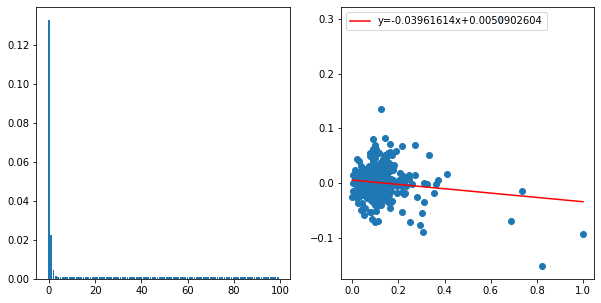

In [ ]:
## You need to visualized a relational graph
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.bar(range(100), loss_epoch)
ax2.scatter(train_x, train_y)
x = np.linspace(0,1,100)
linear_weight = model.linear_classifier.weight.detach().numpy()
lienar_bias = model.linear_classifier.bias.detach().numpy()
y = linear_weight*x+lienar_bias
y = y.reshape((100))
ax2.plot(x, y, '-r', label='y='+str(linear_weight[-1][-1])+'x+'+str(lienar_bias[-1]))
ax2.legend(loc='upper left')

# 6. Prediction

In [ ]:
def predict(key_count, model):
  model.eval()
  logit = model(key_count)
  return logit

In [ ]:
key_count = np.array([41])
scaled_input = scaler.transform(key_count.reshape(1,-1))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [ ]:
df_all.max()
predicted = predict(torch.FloatTensor(scaled_input), model)

In [ ]:
print("검색량이"+str(key_count)+"일때 주가는", str(predicted.item()*100) )

검색량이[41]일때 주가는 -0.5346785765141249


In [ ]:
# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)


# make dataset to train